In [1]:
import pandas as pd
import numpy as np

In [62]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

a=api.dataset_download_files('catherinerasgaitis/mxmh-survey-results')
# KaggleApi를 통해 catherinerasgaitis/mxmh-survey-results을 불러온다.
# url: https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results
import zipfile

zip_path = 'C:/Users/USER/Desktop/2023-2/오픈소스개발프로젝트/mxmh-survey-results.zip'  # 압축 파일 경로
extract_path = 'C:/Users/USER/Desktop/2023-2/오픈소스개발프로젝트'  # 압축 해제 경로

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [92]:
import re
from dateutil import parser

import numpy as np
import pandas as pd
import altair as alt
import missingno as msn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [65]:
def calculateMeanOrModePerColumnWithMissingValues(dataset, targetColumn:str) -> list:
    
    # Get the list of fav genres per null values
    favGenres = dataset.loc[dataset[targetColumn].isnull(), 'Fav genre'].tolist()
    # Dictionary with the values for NA per column
    restultDict = {}
    # Process for columns with numerical values
    try:
        for favGenre in favGenres:
            mean = int((dataset[dataset["Fav genre"] == favGenre][targetColumn].mean()).round())
            restultDict[favGenre] = mean
        return restultDict
    # Process for columns with string values
    except:
        for favGenre in favGenres:
            mode = dataset[dataset["Fav genre"] == favGenre][targetColumn].mode().iloc[0]
            restultDict[favGenre] = mode
        return restultDict

def fillUpEmptyFieldsByColumn(dataset, columnNames, calculateMeanOrModePerColumnWithMissingValuesMethod):
    
    # Iterate over the list of column names
    for columnName in columnNames:
        # Identify if that column has any empty value
        if dataset[columnName].isna().any():
            # If true, then calculates the mean or mode for that column by fav music genre
            valuesReplacement = calculateMeanOrModePerColumnWithMissingValuesMethod(dataset=dataset, targetColumn=columnName)
            # Iterates over each row of the given dataset
            for index, row in dataset.iterrows():
                # Check if that row has and empty value in the current iteration of column name
                if pd.isna(row[columnName]) and row["Fav genre"] in valuesReplacement:
                    # If true, then fill up that empty cell with its regarding mean or mode by favorite music genre
                    dataset.at[index, columnName] = valuesReplacement[row["Fav genre"]]
    # Returns a new dataset without empty cells
    return dataset

def createBoxplotChart(dataset, axis_y:str):
    
    # Create a boxplot chart without style parameters
    boxplotChart = alt.Chart(dataset).mark_boxplot().encode(
    alt.X("Fav genre:N"),
    alt.Y(f"{axis_y}:Q")
    )
    # Returns the chart
    return boxplotChart

def graphPeopleByPathologyAndMusicGenre(dataset, pathologyThreshold:int, pathologyName:str, musicGenreFrecuency="Very frequently"):
   
    # Get music genres columns names
    columnNames = [column for column in dataset.columns if re.match(r"Frequency\b", column)]
    # Specify pathology threshold
    threshold = pathologyThreshold
    # Filter the given dataset by pathology and threshold
    data = dataset[dataset[pathologyName] > threshold]
    # Store music genres and total of people with certain 
    # pathology listening each genre with an specific frequency
    totals = {"genre": [], "total": []}

    # Iterate over each column
    for column in columnNames:
        # Count people by genre
        count = data[data[column] == musicGenreFrecuency][column].count()
        # Store music genre in the dictionary
        totals["genre"].append(column)
        # Store total count in the dictionary
        totals["total"].append(count)

    # Create a temporal dataframe with the needed counts
    df = pd.DataFrame(totals)
    
    # Create a chart for the temporal df results
    chart = alt.Chart(df).mark_bar().encode(
    alt.X("total:Q"),
    alt.Y("genre:N", sort="-x"),
    ).properties(
        title=f"{pathologyName}"
    )
    
    # Create labels for showing the totals by column in the chart
    texts = chart.mark_text(
        align="left",
        baseline="middle"
    ).encode(
        text="total:Q"
    )
    # Combine the bar chart and the text labels
    chart = chart + texts
    # Return a single chart
    return chart

def calculateMeanPerListenersOverAndUnderNinetyBPM(dataset, pathologyName:str) -> dict:
    
    # Calculate mean for people over 90 BPM by the given pathology name
    meanOverLimit = dataset[dataset["BPM over 90"] == 1][pathologyName].mean()
    # Calculate mean for people under 90 BPM by the given pathology name
    meanUnderLimit = dataset[dataset["BPM over 90"] == 0][pathologyName].mean()
    # Create a temporal mino dataframe with the former calculated means
    tempDataset = pd.DataFrame({
        "BPM level": ["BMP over 90", "BPM under 90"],
        "Means": [meanOverLimit, meanUnderLimit]
        })
    
    # Create a single bar chart showing labels and means
    chart = alt.Chart(tempDataset).mark_bar().encode(
        alt.X("BPM level:N", title="BPM music level people listen to"),
        alt.Y("Means:Q", title="Mean Level"),
        color=alt.condition(
            alt.datum["Means"] < 5,
            alt.value("green"),
            alt.value("red")
        )
    ).properties(
        title=f"{pathologyName} mean comparison for 90 BPM music listeners and no listeners"
    )
    
    # Return bar chart
    return chart

In [67]:
dataset = pd.read_csv("C:/Users/USER/Desktop/2023-2/오픈소스개발프로젝트/mxmh_survey_results.csv")

In [68]:
dataset.head(5)

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


In [69]:
# View dataset's current columns object types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     736 non-null    object 
 1   Age                           735 non-null    float64
 2   Primary streaming service     735 non-null    object 
 3   Hours per day                 736 non-null    float64
 4   While working                 733 non-null    object 
 5   Instrumentalist               732 non-null    object 
 6   Composer                      735 non-null    object 
 7   Fav genre                     736 non-null    object 
 8   Exploratory                   736 non-null    object 
 9   Foreign languages             732 non-null    object 
 10  BPM                           629 non-null    float64
 11  Frequency [Classical]         736 non-null    object 
 12  Frequency [Country]           736 non-null    object 
 13  Frequ

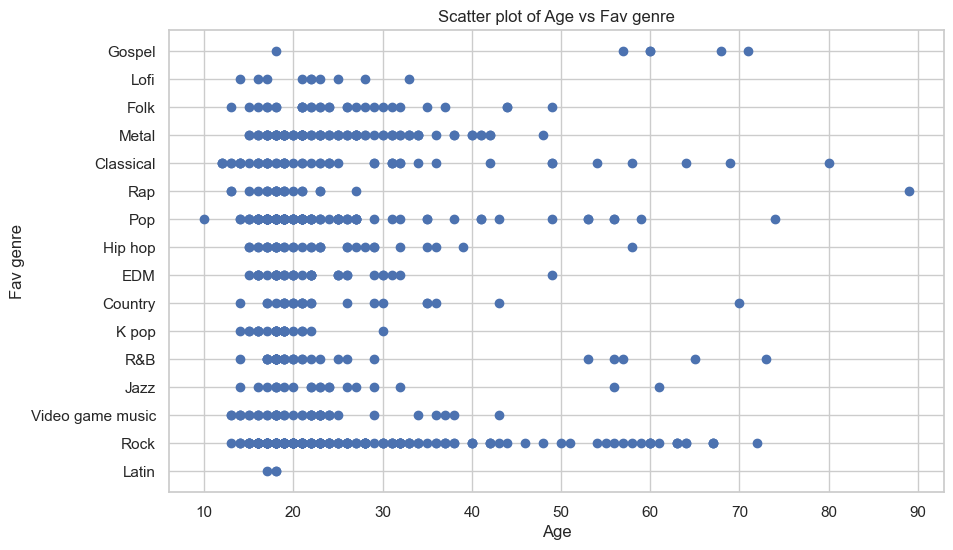

In [80]:
#matplotlib 활용 그래프
plt.figure(figsize=(10,6))
plt.scatter(dataset['Age'], dataset['Fav genre'])
plt.title('Scatter plot of Age vs Fav genre')
plt.xlabel('Age')
plt.ylabel('Fav genre')
plt.show()

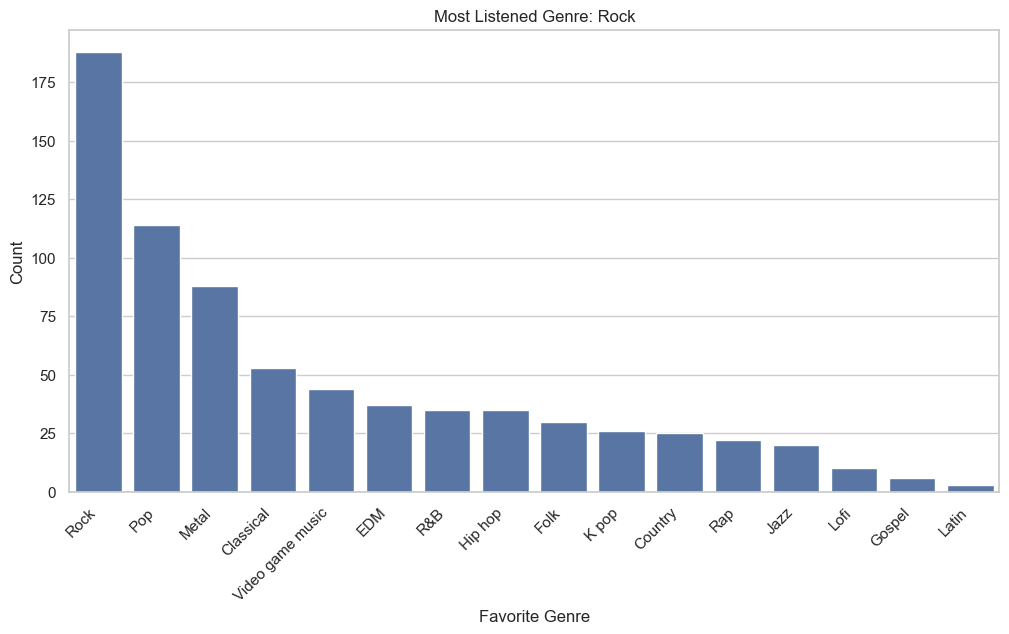

In [91]:
#seaborn 활용 그래프
# 'Fav genre' 열의 가장 많이 등장하는 음악 장르 찾기
most_frequent_genre = dataset['Fav genre'].mode().values[0]

# 가장 많이 듣는 음악 장르에 대한 카운트
genre_count = dataset['Fav genre'].value_counts()

# 가장 많이 듣는 음악 장르에 대한 바 그래프
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_count.index, y=genre_count.values)
plt.title(f'Most Listened Genre: {most_frequent_genre}')
plt.xlabel('Favorite Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # x축 레이블 회전
plt.show()



In [117]:
'''
First, it was identified all the columns in dataset with values
with numeric type since those are the ones with probability of
having drastic outliers. It was used the technique of graphic
visualization first. The one choosen was a boxplot chart due to 
the accuracy offered by the quartiles calculation. The pourpose 
was look up if there were columns with events out of their own mean 
and it was found a column that actually does.

The unique chart that actually breaks its own measure scale and has 
a value far from the rest of the dataset is the based on the axis Y
'BPM'. That insight makes sense due to is the one with the most of
the missing values in the dataset.

Now that the outliers were found is necessary to fix them.
'''

outlierForAge = createBoxplotChart(dataset=dataset, axis_y="Age")

outlierForHoursPerDay = createBoxplotChart(dataset=dataset, axis_y="Hours per day")

outlierForAnxiety = createBoxplotChart(dataset=dataset, axis_y="Anxiety")

outlierForDepression = createBoxplotChart(dataset=dataset, axis_y="Depression")

outlierForInsomnia = createBoxplotChart(dataset=dataset, axis_y="Insomnia")

outlierForOCD = createBoxplotChart(dataset=dataset, axis_y="OCD")

outlierGeneralChart = outlierForAge & outlierForHoursPerDay | outlierForOCD & outlierForAnxiety | outlierForDepression & outlierForInsomnia

# General boxplot chart visualization
outlierGeneralChart

alt.HConcatChart(...)

In [74]:
'''
In order to confirm the former finding an individual test was
applied. For this pourpose it was used the previous function to 
calculate mean and mode by column, in this case, for the 'BPM' 
column grouped by Favorite music genre.

The mean bpm for the 'Video game music' genre is overstated, that
confirms something goes wrong with that nominal category in that
specific column.
'''

# Calculate mean for the 'BPM' column by favorite genre
bpmMean = calculateMeanOrModePerColumnWithMissingValues(dataset=dataset, targetColumn="BPM")

# Show result
bpmMean

{'Country': 110,
 'Hip hop': 112,
 'Pop': 119,
 'Rock': 124,
 'Metal': 139,
 'Classical': 115,
 'Video game music': 27027144,
 'R&B': 114,
 'Folk': 110,
 'Jazz': 124,
 'EDM': 148,
 'Gospel': 89,
 'K pop': 129,
 'Rap': 127}

In [75]:
'''
Rock, Pop and Metal are the common genres between people with 
pathology levels higher than 5 points. This insight could mean
two statements.

1) Rock, Pop and Metal are just the most popular music genres
and that fact makes them the easy to be chosen between people
with any type of disorder.
2) Rock, Pop and Metal has a negative impact in people mental
health.
'''

anxietyCount = graphPeopleByPathologyAndMusicGenre(dataset=dataset,
                                                    pathologyThreshold=5,
                                                    pathologyName="Anxiety")

depressionCount = graphPeopleByPathologyAndMusicGenre(dataset=dataset,
                                                    pathologyThreshold=5,
                                                    pathologyName="Depression")

insomniaCount = graphPeopleByPathologyAndMusicGenre(dataset=dataset,
                                                    pathologyThreshold=5,
                                                    pathologyName="Insomnia")

ocdCount = graphPeopleByPathologyAndMusicGenre(dataset=dataset,
                                                    pathologyThreshold=5,
                                                    pathologyName="OCD")

# Concatenate charts 
pathologiesGeneralChart = anxietyCount & depressionCount | insomniaCount & ocdCount

# Show general chart
pathologiesGeneralChart

alt.HConcatChart(...)

In [119]:
'''
Most of the people listen to music over 90 BPM, probably related
to Rock, Pop and Metal music which could make sense along the
result of the former question.
'''


# Limits to cut each label rank
bins = [0, 50, 70, 90, 110, 130, 150, 170, 190, 210]

# Labels to name each rank created
labels = ["0 - 50", "51 - 70", "71 - 90", "91 - 110", "111 - 130", "131 - 150", "151 - 170", "171 - 190", 'Más de 200']

# Cut the 'BPM' column into ranks
dataset["BPM ranks"] = pd.cut(dataset["BPM"], bins=bins, labels=labels)

# Temporal dataset with the total count of people by BPM rank
ranksCounts = dataset["BPM ranks"].value_counts().reset_index()

# Rename columns of the temporal dataset
ranksCounts.columns = ["BPM ranks", "Count"]

# Chart of BPM ranks and count of listeners
chart = alt.Chart(ranksCounts).mark_bar().encode(
    alt.X("BPM ranks:N", title="BPM ranks", sort="-y"),
    alt.Y("Count:Q", title="Listeners total count")
)

# Total count labels
labels = chart.mark_text().encode(
    text="Count:Q",
)

# Concatenate bar chart and labels
chart = chart + labels

# Show chart
chart

alt.LayerChart(...)

            Timestamp   Age Primary streaming service  Hours per day  \
0  8/27/2022 19:29:02  18.0                   Spotify            3.0   
1  8/27/2022 19:57:31  63.0                   Pandora            1.5   
2  8/27/2022 21:28:18  18.0                   Spotify            4.0   
3  8/27/2022 21:40:40  61.0             YouTube Music            2.5   
4  8/27/2022 21:54:47  18.0                   Spotify            4.0   

  While working Instrumentalist Composer         Fav genre Exploratory  \
0           Yes             Yes      Yes             Latin         Yes   
1           Yes              No       No              Rock         Yes   
2            No              No       No  Video game music          No   
3           Yes              No      Yes              Jazz         Yes   
4           Yes              No       No               R&B         Yes   

  Foreign languages  ...  Frequency [Rock] Frequency [Video game music]  \
0               Yes  ...             Never     

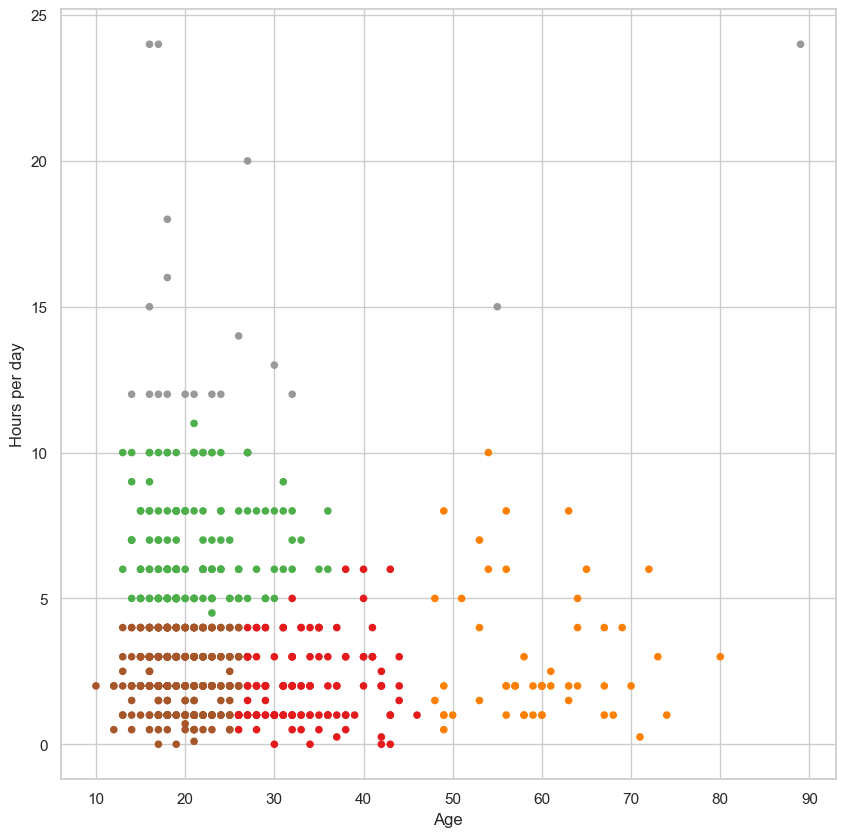

In [125]:
print(dataset.head())
print('\n')

print(dataset.info())
print('\n')

print(dataset.describe())

numerical_features = ['Age', 'Hours per day']
X=dataset.loc[:, numerical_features]
print(X[:5])
print('\n')

from sklearn import preprocessing

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
X= preprocessing.StandardScaler().fit_transform(X)

print(X[:5])

from sklearn import cluster

kmeans=cluster.KMeans(init='k-means++',n_clusters=5,n_init=10)

kmeans.fit(X)

cluster_label=kmeans.labels_
print(cluster_label)
print('\n')

dataset['Cluster']=cluster_label
print(dataset.head())

dataset.plot(kind='scatter',x='Age',y='Hours per day',c='Cluster',cmap='Set1',colorbar=False,figsize=(10,10))


plt.show()
plt.close()